In [1]:
import utils; reload(utils)
from utils import *
%matplotlib inline


Using gpu device 0: GeForce GTX 1080 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5005)
Using Theano backend.


In [2]:
DATA_DIR = '/home/chicm/data/cervc/orig'
TRAIN_DIR = DATA_DIR+'/train'
TEST_DIR = DATA_DIR + '/test'
VALID_DIR = DATA_DIR + '/valid'
RESULT_DIR = DATA_DIR + '/results'
batch_size = 64

In [3]:
batches = get_batches(TRAIN_DIR, batch_size=batch_size)
val_batches = get_batches(VALID_DIR, batch_size=batch_size, shuffle = False)
(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(DATA_DIR+'/')

Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 512 images belonging to 1 classes.


In [4]:
raw_filenames = ['/'.join(f.split('/')[-2:]) for f in filenames]
raw_test_filenames = ['/'.join(f.split('/')[-2:]) for f in test_filenames]
raw_val_filenames = ['/'.join(f.split('/')[-2:]) for f in val_filenames]
print raw_filenames[:5]
print raw_test_filenames[:5]
print raw_val_filenames[:5]

['Type_1/560.jpg', 'Type_1/416.jpg', 'Type_1/846.jpg', 'Type_1/532.jpg', 'Type_1/1230.jpg']
['unknown/17.jpg', 'unknown/416.jpg', 'unknown/372.jpg', 'unknown/44.jpg', 'unknown/94.jpg']
['Type_1/763.jpg', 'Type_1/1390.jpg', 'Type_1/653.jpg', 'Type_1/645.jpg', 'Type_1/873.jpg']


In [88]:
sizes = [PIL.Image.open(TRAIN_DIR+'/'+f).size for f in filenames]
val_sizes = [PIL.Image.open(VALID_DIR+'/'+f).size for f in val_filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [89]:
print sizes[:5]
print val_sizes[:5]

[(3096, 4128), (2448, 3264), (2448, 3264), (2448, 3264), (3096, 4128)]
[(3096, 4128), (3096, 4128), (3096, 4128), (3120, 4160), (2448, 3264)]


# create validation data

In [5]:
import numpy as np
import os,sys,shutil,glob
def create_validation_data():
    os.chdir(TRAIN_DIR)
    files = glob.glob('*/*.jpg')

    #drivers = sorted(driver2imgs.keys())
    files = np.random.permutation(files)
    print files[:10]

    for i in range(150):
        fn = files[i]
        #print TRAIN_DIR+'/'+fn
        shutil.move(TRAIN_DIR+'/'+fn, VALID_DIR+'/'+fn)
#create_validation_data()

['Type_3/492.jpg' 'Type_2/443.jpg' 'Type_2/1371.jpg' 'Type_2/8.jpg' 'Type_2/279.jpg'
 'Type_2/990.jpg' 'Type_2/647.jpg' 'Type_2/1181.jpg' 'Type_3/1459.jpg' 'Type_3/993.jpg']


## Basic VGG

In [5]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(3)

In [6]:
trn = get_data(TRAIN_DIR)
val = get_data(VALID_DIR)

Found 1330 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [7]:
test = get_data(TEST_DIR)

Found 512 images belonging to 1 classes.


In [8]:
save_array(RESULT_DIR+'/trn.dat', trn)
save_array(RESULT_DIR+'/val.dat', val)
save_array(RESULT_DIR+'/test.dat', test)

In [9]:
trn = load_array(RESULT_DIR+'/trn.dat')
val = load_array(RESULT_DIR+'/val.dat')
test = load_array(RESULT_DIR+'/test.dat')

In [10]:
gen = image.ImageDataGenerator()

In [11]:
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=10, validation_data=(val, val_labels))

Train on 1330 samples, validate on 150 samples
Epoch 1/10
1330/1330 [==============================] - 11s - loss: 2.8302 - acc: 0.4474 - val_loss: 1.5591 - val_acc: 0.5467

In [13]:
model.save_weights(RESULT_DIR+'/ft1.h5')

## precompute vonv output

In [14]:
model.load_weights(RESULT_DIR+'/ft1.h5')

In [15]:
conv_layers, fc_layers = split_at(model, Convolution2D)

In [16]:
conv_model = Sequential(conv_layers)

In [17]:
conv_feat = conv_model.predict(trn)

In [18]:
conv_val_feat = conv_model.predict(val)

In [19]:
conv_test_feat = conv_model.predict(test)

In [20]:
save_array(RESULT_DIR+'/conv_feat.dat', conv_feat)
save_array(RESULT_DIR+'/conv_val_feat.dat', conv_val_feat)
save_array(RESULT_DIR+'/conv_test_feat.dat', conv_test_feat)

In [21]:
conv_feat = load_array(RESULT_DIR+'/conv_feat.dat')
conv_val_feat = load_array(RESULT_DIR+'/conv_val_feat.dat')
conv_test_feat = load_array(RESULT_DIR+'/conv_test_feat.dat')

## train model

In [22]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(3, activation='softmax')
    ]

In [23]:
p = 0.6

In [24]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(conv_val_feat, val_labels))

Train on 1330 samples, validate on 150 samples
Epoch 1/3
1330/1330 [==============================] - 0s - loss: 1.5944 - acc: 0.4120 - val_loss: 5.7053 - val_acc: 0.3000
Epoch 2/3
1330/1330 [==============================] - 0s - loss: 0.9186 - acc: 0.6308 - val_loss: 2.5866 - val_acc: 0.4533

In [26]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))


Train on 1330 samples, validate on 150 samples
Epoch 1/7
1330/1330 [==============================] - 0s - loss: 0.4015 - acc: 0.8602 - val_loss: 1.7041 - val_acc: 0.5467
Epoch 2/7
1330/1330 [==============================] - 0s - loss: 0.2290 - acc: 0.9241 - val_loss: 1.4810 - val_acc: 0.5800

In [27]:
bn_model.save_weights(RESULT_DIR+'/conv_512_6.h5')

In [28]:
bn_model.load_weights(RESULT_DIR+'/conv_512_6.h5')

In [32]:
bn_model.evaluate(conv_val_feat, val_labels)

 32/150 [=====>........................] - ETA: 0s

[1.6074033244450887, 0.62000000238418584]

## import boundary box

In [33]:
import pandas as pd

In [45]:
t1df = pd.read_csv('/home/chicm/ml/cnnpractices/cervc/Type_1_bbox.tsv', sep=' ', header=None)
t2df = pd.read_csv('/home/chicm/ml/cnnpractices/cervc/Type_2_bbox.tsv', sep=' ', header=None)
t3df = pd.read_csv('/home/chicm/ml/cnnpractices/cervc/Type_3_bbox.tsv', sep=' ', header=None)

In [52]:
t2df.head()

,0,1,2,3,4,5
0,Type_2\1.jpg,1,918,1814,492,411
1,Type_2\100.jpg,1,1116,1057,764,544
2,Type_2\1001.jpg,1,1354,2873,590,742
3,Type_2\1002.jpg,1,720,1109,506,693
4,Type_2\1005.jpg,1,1048,1223,1372,1861


In [69]:

dict1 = {row.tolist()[0].replace('\\', '/'): row.tolist()[2:6] for i,row in t1df.iterrows()}
dict2 = {row.tolist()[0].replace('\\', '/'): row.tolist()[2:6] for i,row in t2df.iterrows()}
dict3 = {row.tolist()[0].replace('\\', '/'): row.tolist()[2:6] for i,row in t3df.iterrows()}

bbdict = dict(dict(dict1.items() + dict2.items()).items() + dict3.items())
print len(bbdict.keys())

print bbdict.keys()[:5]
#print type(dict1.keys())


1466
['Type_2/607.jpg', 'Type_2/990.jpg', 'Type_2/283.jpg', 'Type_1/809.jpg', 'Type_2/1057.jpg']


In [70]:
empty_bbox = [0, 0, 0, 0]
print bbdict.keys()[:5]
print raw_filenames[:5]

['Type_2/607.jpg', 'Type_2/990.jpg', 'Type_2/283.jpg', 'Type_1/809.jpg', 'Type_2/1057.jpg']
['Type_1/560.jpg', 'Type_1/416.jpg', 'Type_1/846.jpg', 'Type_1/532.jpg', 'Type_1/1230.jpg']


In [74]:
count = 0
for f in raw_filenames:
    if not f in bbdict.keys():
        bbdict[f] = empty_bbox
        count+=1
for f in raw_val_filenames:
    if not f in bbdict.keys():
        bbdict[f] = empty_bbox
        count+=1
print count

0


In [96]:
def convert_bb(bb, size):
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    newbb = [0,0,0,0]
    newbb[0] = bb[0]*conv_x
    newbb[1] = bb[1]*conv_y
    newbb[2] = bb[2]*conv_x
    newbb[3] = bb[3]*conv_y
    return newbb

In [97]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[0],bb[1]), bb[2], bb[3], color=color, fill=False, lw=3)
def show_bb(i):
    fn = raw_val_filenames[i]
    print fn
    bb = bbdict[fn]
    print bb
    print val_sizes[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(convert_bb(bb, val_sizes[i])))

Type_2/198.jpg
[1066, 1317, 890, 723]
(3096, 4128)


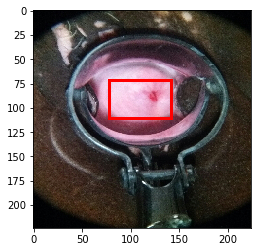

In [103]:
show_bb(100)

In [101]:
trn_bbox = np.stack([convert_bb(bbdict[f], s) for f, s in zip(raw_filenames, sizes)]).astype(np.float32)
print trn_bbox[0]
val_bbox = np.stack([convert_bb(bbdict[f], s) for f, s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)
print val_bbox[0]              

[ 103.0284   84.814    40.3721   44.9845]
[  68.7338  110.9147   99.845    74.8837]


## create and train model